# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [46]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [47]:
# run once to set paths
if False:
    # import without being in workon env
    import os
    import sys
    py_ver = sys.version_info[0]

    # for python3
    if py_ver == 3:
        sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
        sys.path.remove('/home/emaggard/catkin_ws/devel/lib/python2.7/dist-packages')


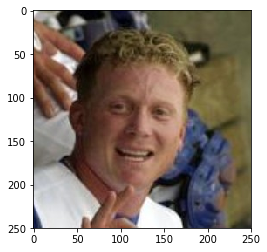

Number of faces detected: 1


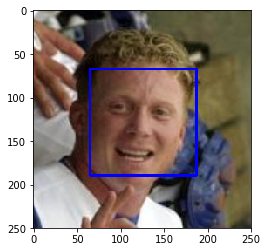

In [48]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [49]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
There were 97 out of 100 images that correctly identified a human face (97%).  However, there were 18 out of 100 dog images where a human face was incorrectly identified (18%).  It was pretty good at identifying a human but had not so good false positives.

In [50]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
face_true = 0;
for img in human_files_short:
    if face_detector(img):
        face_true += 1;
        
print('Number of faces detected: ' + str(face_true) + ' out of ' + str(len(human_files_short)) + ' images.  Percentage: ' + str((face_true/len(human_files_short))*100))

face_true = 0;

for img in dog_files_short:
    if face_detector(img):
        face_true += 1;
        
print('Number of incorrect faces detected: ' + str(face_true) + ' out of ' + str(len(dog_files_short)) + ' images.  Percentage: ' + str((face_true/len(dog_files_short))*100))


Number of faces detected: 97 out of 100 images.  Percentage: 97.0
Number of incorrect faces detected: 18 out of 100 images.  Percentage: 18.0


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [51]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [52]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    VGG16.eval()
    img = Image.open(img_path)
    img_transform = transforms.Compose([
                        transforms.Resize(size=(224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    img_trans = img_transform(img).unsqueeze(0)
    
    ## Return the *index* of the predicted class for that image
    if use_cuda:
        img_trans = img_trans.cuda()
        
    pred = VGG16(img_trans)
    top_class = pred.topk(1)[1].item()
    
    return top_class # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [53]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred_class = VGG16_predict(img_path)
    return pred_class >= 151 and pred_class <= 268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
The VGG16 pretrained model did very well at identifying dogs in the correct images (93%) and didn't have one misclassification for a dog in a human image.

In [54]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_true = 0;
for img in human_files_short:
    if dog_detector(img):
        dog_true += 1;
        
print('Number of dogs detected: ' + str(dog_true) + ' out of ' + str(len(human_files_short)) + ' humans.  Percentage: ' + str((dog_true/len(human_files_short))*100))

dog_true = 0;
for img in dog_files_short:
    if dog_detector(img):
        dog_true += 1;
        
print('Number of dogs detected: ' + str(dog_true) + ' out of ' + str(len(dog_files_short)) + ' dogs.  Percentage: ' + str((dog_true/len(dog_files_short))*100))


Number of dogs detected: 0 out of 100 humans.  Percentage: 0.0
Number of dogs detected: 93 out of 100 dogs.  Percentage: 93.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [64]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

import torch
import torchvision.models as models

# define ResNet model
resnet = models.resnet50(pretrained='imagenet')
#incept3 = models.inception_v3(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    resnet = resnet.cuda()
    #incept3 = incept3.cuda()


In [65]:
def opt_predict(img_path):
    '''
    Use pre-trained resnet50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to resnet model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    resnet.eval()
    img = Image.open(img_path)
    img_transform = transforms.Compose([
                        transforms.Resize(size=(224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    img_trans = img_transform(img).unsqueeze(0)
    
    ## Return the *index* of the predicted class for that image
    if use_cuda:
        img_trans = img_trans.cuda()
        
    pred = resnet(img_trans)
    #pred = incept3(img_trans)
    top_class = pred.topk(1)[1].item()
    
    return top_class # predicted class index

In [66]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_resnet(img_path):
    ## TODO: Complete the function.
    pred_class = opt_predict(img_path)
    #print(pred_class)
    return pred_class >= 151 and pred_class <= 268 # true/false

In [67]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_true = 0;
for img in human_files_short:
    if dog_detector_resnet(img):
        dog_true += 1;
        
print('Number of dogs detected: ' + str(dog_true) + ' out of ' + str(len(human_files_short)) + ' humans.  Percentage: ' + str((dog_true/len(human_files_short))*100))

dog_true = 0;
for img in dog_files_short:
    if dog_detector_resnet(img):
        dog_true += 1;
        
print('Number of dogs detected: ' + str(dog_true) + ' out of ' + str(len(dog_files_short)) + ' dogs.  Percentage: ' + str((dog_true/len(dog_files_short))*100))


Number of dogs detected: 1 out of 100 humans.  Percentage: 1.0
Number of dogs detected: 96 out of 100 dogs.  Percentage: 96.0


ResNet50 did slightly better then VGG16, with 96% on dogs, and 1 misclassification on humans

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
import os
import torch
from torchvision import datasets,transforms
from PIL import Image
import matplotlib.pyplot as plt

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# variables
batch_size = 10
num_workers = 1

# image paths
train_folder = "data/dogImages/train"
valid_folder = "data/dogImages/valid"
test_folder = "data/dogImages/test"

# transforms
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize(256),
                                    transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]) 
test_transforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]) 


# data loaders
train_data = datasets.ImageFolder(train_folder,transform=train_transforms)
valid_data = datasets.ImageFolder(valid_folder,transform=test_transforms)
test_data = datasets.ImageFolder(test_folder,transform=test_transforms)

print('Number of training images: ' + str(len(train_data)))
print('Number of validation images: ' + str(len(valid_data)))
print('Number of testing images: ' + str(len(test_data)))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_scratch={
    "train":train_loader,
    "valid":valid_loader,
    "test": test_loader
}

print('Transforms and Loaders setup...')

Number of training images: 6680
Number of validation images: 835
Number of testing images: 836
Transforms and Loaders setup...


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: For the training set, I wanted to do data augmemtation, so I did a random rotation of +/- 15 degrees and did a random horizontal flip.  I then resized the images to 256 and then did a random center crop to get the image to 224 x 224 pixels.  I picked that because that is the standard tensor size for the CNN trained on the ImageNet dataset.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:
# basic one trying to get running
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

# variables
CLASSES = 133
DROPOUT = 0.25

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # normalization layers
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layers
        self.fc1 = nn.Linear(128 * 28 * 28, 1500)
        self.fc2 = nn.Linear(1500, 500)
        self.fc3 = nn.Linear(500, CLASSES)
        # dropout layer 
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        # first layer
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool(x)
        # second layer
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pool(x)
        # third layer
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool(x)
        # fourth layer
        x = F.relu(self.conv4(x))
        # flatten image input
        x = x.view(-1, 128 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # output layer
        #x = self.fc3(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [3]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)


In [4]:
from torchsummary import summary

summary(model_scratch,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
          Dropout-11               [-1, 100352]               0
           Linear-12                 [-1, 1500]     150,529,500
          Dropout-13                 [-1, 1500]               0
           Linear-14                  [

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ I started off with the network defined in class, and adjusted the length of the tensor correctly.  But that didn't perform well, so I added another Conv2d layer and increased the depth of the layers.  I increased the depth of the layers so it could try to learn the features better.  I also added batch normalization so it would normalize the layers and help train faster.  I had a hard time getting it working, and then realized that I didn't do the softmax at the last layer.  I am not sure this was really needed, but the training worked well and after 110 epochs the validation and training loss were flattening. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [19]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.1)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [20]:
# the following import is required for training to be robust to truncated images
import numpy as np
import sys
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # calculate loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss)).item()
            
            sys.stdout.write('Batch idx: {}/{}\r'.format(batch_idx+1, len(loaders['train'])))
            sys.stdout.flush()
            
            
        ######################    
        # validate the model #
        ######################
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss)).item()
            
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)        
            valid_loss_min = valid_loss
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} ----> model saved...'.format(
                epoch, 
                train_loss,
                valid_loss
                ))
            
        else:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

    # return trained model
    return model


In [70]:
# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch: 1 	Training Loss: 3.856505 	Validation Loss: 3.418720 ----> model saved...
Epoch: 2 	Training Loss: 3.894145 	Validation Loss: 3.442294
Epoch: 3 	Training Loss: 3.887593 	Validation Loss: 3.482923
Epoch: 4 	Training Loss: 3.859217 	Validation Loss: 3.424160
Epoch: 5 	Training Loss: 3.893827 	Validation Loss: 3.340864 ----> model saved...
Epoch: 6 	Training Loss: 3.831975 	Validation Loss: 3.696927
Epoch: 7 	Training Loss: 3.908757 	Validation Loss: 3.562005
Epoch: 8 	Training Loss: 3.845776 	Validation Loss: 3.336126 ----> model saved...
Epoch: 9 	Training Loss: 3.851932 	Validation Loss: 3.628617
Epoch: 10 	Training Loss: 3.920357 	Validation Loss: 3.520781


In [71]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [72]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [73]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.361659


Test Accuracy: 17% (150/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [41]:
## TODO: Specify data loaders

import os
import torch
from torchvision import datasets,transforms
from PIL import Image
import matplotlib.pyplot as plt

# variables
batch_size = 10
num_workers = 1

# image paths
train_folder = "data/dogImages/train"
valid_folder = "data/dogImages/valid"
test_folder = "data/dogImages/test"

# transforms
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize(256),
                                    transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]) 
test_transforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]) 


# data loaders
train_data = datasets.ImageFolder(train_folder,transform=train_transforms)
valid_data = datasets.ImageFolder(valid_folder,transform=test_transforms)
test_data = datasets.ImageFolder(test_folder,transform=test_transforms)

print('Number of training images: ' + str(len(train_data)))
print('Number of validation images: ' + str(len(valid_data)))
print('Number of testing images: ' + str(len(test_data)))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_transfer={
    "train":train_loader,
    "valid":valid_loader,
    "test": test_loader
}

print('Transforms and Loaders setup...')

Number of training images: 6680
Number of validation images: 835
Number of testing images: 836
Transforms and Loaders setup...


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
import torchvision.models as models
import torch.nn as nn

# variables
CLASSES = 133

# define ResNet model
model_transfer = models.resnet50(pretrained=True)
#model_transfer = models.inception_v3(pretrained=True)


In [27]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [28]:
# don't need to train
for param in model_transfer.parameters():
    param.required_grad = False
    
# replace fully convolutional layers
last_layer = nn.Linear(2048, CLASSES)

model_transfer.fc = last_layer

# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I used the ResNet50 architecture and substituted the final fully connnected layer with one that cuts it down to the dog classes for training.  I think that network is a good substitute between performance and size.  A larger network such as Inception or ResNet152 could perform a little better, but the speed would be a little slower.  The final result was 88%, so I think the network performed well.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.parameters(),lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
# train the model
model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 1.572986 	Validation Loss: 0.658379 ----> model saved...
Epoch: 2 	Training Loss: 1.504931 	Validation Loss: 0.606109 ----> model saved...
Epoch: 3 	Training Loss: 1.422067 	Validation Loss: 0.548195 ----> model saved...
Epoch: 4 	Training Loss: 1.347962 	Validation Loss: 0.542157 ----> model saved...
Epoch: 5 	Training Loss: 1.304282 	Validation Loss: 0.535679 ----> model saved...
Epoch: 6 	Training Loss: 1.280081 	Validation Loss: 0.495981 ----> model saved...
Epoch: 7 	Training Loss: 1.215801 	Validation Loss: 0.476780 ----> model saved...
Epoch: 8 	Training Loss: 1.153072 	Validation Loss: 0.458535 ----> model saved...
Epoch: 9 	Training Loss: 1.125069 	Validation Loss: 0.445450 ----> model saved...
Epoch: 10 	Training Loss: 1.114352 	Validation Loss: 0.445425 ----> model saved...
Epoch: 11 	Training Loss: 1.074341 	Validation Loss: 0.420787 ----> model saved...
Epoch: 12 	Training Loss: 1.030308 	Validation Loss: 0.413911 ----> model saved...
Epoch: 13 	Tr

In [35]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.348637


Test Accuracy: 88% (742/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [44]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

use_cuda = torch.cuda.is_available()

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # open image
    img = Image.open(img_path)
    # setup transform
    trans = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    # apply transform
    img = trans(img).unsqueeze(0)
    # use cuda
    if use_cuda:
        img = img.cuda()
        
    # get prediction
    output = model_transfer(img)
    _, predicted = output.topk(1)
    idx = predicted.item() 
    
    return class_names[idx]

print(class_names)

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [45]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    # open and show image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        print('Hello Human...')
        print('you look like a...')
        print(predict_breed_transfer(img_path))
    elif dog_detector(img_path):
        print('Dog detected...')
        print('the breed appears to be a...')
        print(predict_breed_transfer(img_path))
    else:
        print('ERROR: neither human or dog were detected')


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)  I think the performance was better than I expected.  I identified all of the humans as humans and same with the dogs, and it didn't get an error on any image.  I did check the actual dog breed, but looking through them they appear correct.  I would probably train the transfer model some more to improve it.  Another way potentially improve it will be to do additional data augmentation like luminance adjustment or more rotation.

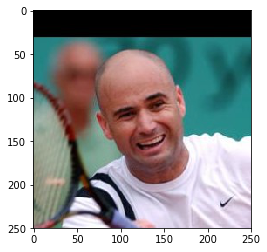

Hello Human...
you look like a...
Ibizan hound


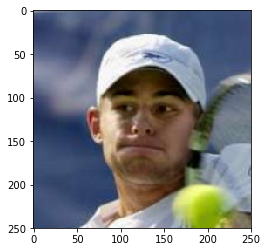

Hello Human...
you look like a...
Clumber spaniel


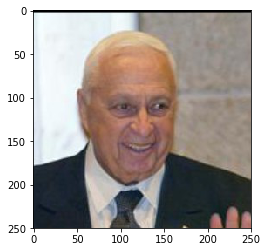

Hello Human...
you look like a...
Bullmastiff


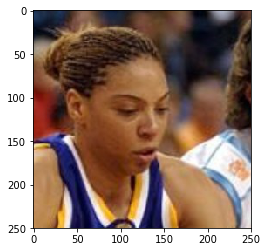

Hello Human...
you look like a...
American water spaniel


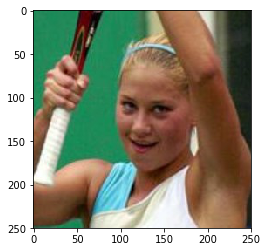

Hello Human...
you look like a...
Ibizan hound


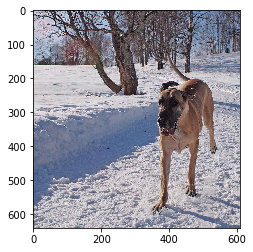

Dog detected...
the breed appears to be a...
Great dane


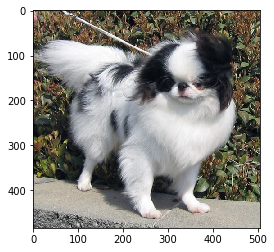

Dog detected...
the breed appears to be a...
Japanese chin


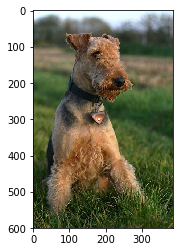

Dog detected...
the breed appears to be a...
Airedale terrier


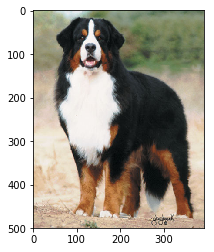

Hello Human...
you look like a...
Bernese mountain dog


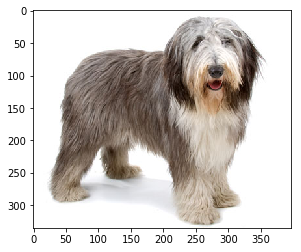

Dog detected...
the breed appears to be a...
Bearded collie


In [63]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# generate random index:
human_idx = []
dog_idx = []
import random
for x in range(5):
    human_idx.append(human_files[random.randint(1,1001)])
    dog_idx.append(dog_files[random.randint(1,1001)])

## suggested code, below
#for file in np.hstack((human_files[:3], dog_files[:3])):
for file in np.hstack((human_idx, dog_idx)):
    run_app(file)